## Visualizing results 8th Edition-  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the **8th Edition of the Encyclopaedia Britannica**. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_8_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_8_edition' -n 16`


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(df_group_places):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['place_label']))
    plt.bar(index, df_group_places['count'], color='green')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['place_label'], rotation=40, fontsize=8)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata


As a result we get a file per gazetter|book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver 
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 


In [7]:
results=read_query_results('georesolution_en_core_web_lg_EB_8_edition')

In [8]:
df_total= geresolution_dataframe(results)

In [9]:
df_total[["Place"]].count()

Place    292839
dtype: int64

In [10]:
df_total["Place"]= df_total["Place"].str.capitalize()

In [11]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
"+2 0,",1,1,1
1 america,1,1,1
1 mill,1,1,1
"1,073,116 deo",1,1,1
"100,1000",1,1,1
1057,1,1,1
"11,320,13,538",1,1,1
1120,1,1,1
114,1,1,1


In [12]:
#df_total.groupby("Page").count()

In [13]:
#df_total.groupby(["Latitude", "Longitude"]).count()

In [14]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

df_max_geolocations = df_filter.drop(0)

df_max_geolocations.head(15)


,Latitude,Longitude,count
8337,34.6120507,-82.765139,3512
1330,-3.4869444,-43.2258333,3323
31047,54,-4,2646
19399,43.2256251,-75.48878740000001,2524
25385,49.012779,2.55,2284
18134,42.4514848,-71.0864414,2134
24086,47.5183,19.10789,1909
9339,36.0300646,-85.3466385,1858
9508,36.2436749,-85.243301,1805
11737,38.7937266,-77.8577722,1644


In [19]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Earth', 'The moon', 'Meridian', 'Jupiter', 'Venus', 'Kingdom', 'Vi', 'Xiv', 'Xxi', 'Ii']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)
    

0 3512 France
2 2646 England
3 2524 Rome
4 2284 Paris
5 2134 England
7 1858 France
8 1805 France
9 1644 England
12 1524 Holland
13 1396 England
14 1302 England
15 1275 Edinburgh
16 1253 Europe
17 1251 Scotland
18 1210 Paris
19 1204 London
20 1163 Russia
22 1060 Great britain
23 1006 Italy
24 992 Scotland
25 973 Greece
26 945 Europe
27 941 Paris
28 894 Asia
29 875 India


In [20]:
#Visualizing the 15 places in a Bar plot
df_places = {'place_label':place_label,'place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['place_label'])['place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,place_label,count
2,England,9122
4,France,7175
11,Paris,4435
12,Rome,2524
14,Scotland,2243
3,Europe,2198
7,Holland,1524
1,Edinburgh,1275
10,London,1204
13,Russia,1163


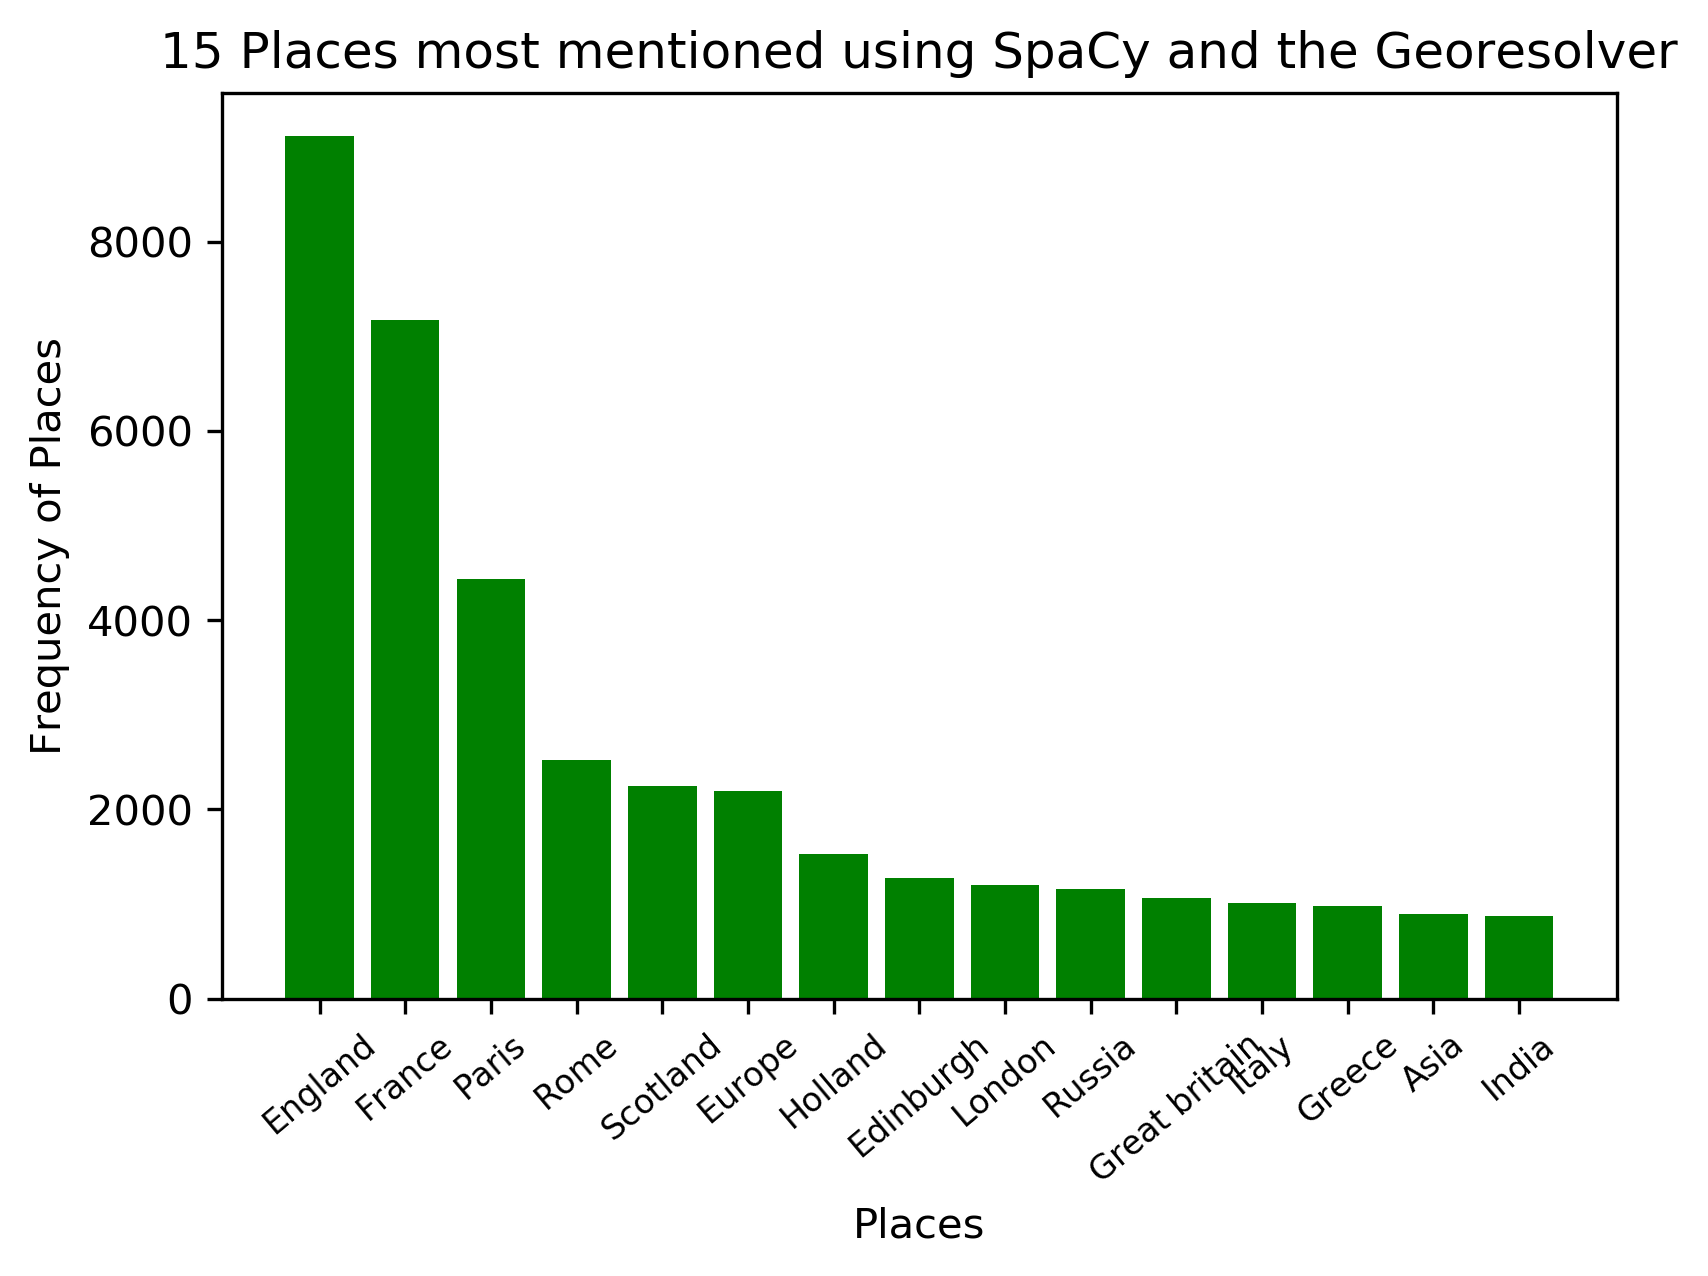

In [21]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places)